# MPO 624 - Homework 3

## Fourier Analysis: 1 and 2D power spectrum

Tiago Carrilho Bilo C#11950866


### Summary of what will be done: 

Lets continue exploring the North Atlantic Meridional Heat Transport (MHT) dataset. In Homerwok 2: Linear modeling, we studied the data trends in time as function of latitude and verified that most of the signal variability is "explained" by the seasonal cycle. 

Here we are going to verify this variations in the context of Fourier Analysis. Our main goal here is to quantify how much of the total variance will be explained by periodic oscillations in time. Additionally, we also are interested in verifying if there are meridional wave-like structures that explain the latitudinal variability of the data in the scope of 2D spectrum analysis. 

As we did in the previous homeworks, we are going to take the latitude of approximately 26.4$^{\circ}$N as a study case. 



## Part 1. Detrending the dataset and computing anomalies

We know our dataset present significant trends south of $\sim$60$^{\circ}$N, since Fourier analysis deal with orthogonal oscillatory variability (i. e., variability described by sines and cosines) we need to remove the mean and the variance explained linear trends. 

Therefore we are going to work with anomalies $MHT'$ defined by:

$$MHT'(t,lat) = MHT - \bar{MHT} - (a \times t + b),$$ 

where $a$ and $b$ define the linear model. Note the similar procidure will be performed in the spatial domain, 

i. e., 

$$ MHT'(t,lat) = MHT - <MHT> - (A \times lat + B),$$

where $<>$ indicate meridional average.


In [1]:
# importing libraries
import numpy as np
import pylab as py
import netCDF4 
import matplotlib.pyplot as plt
import datetime
%matplotlib inline


# Unables latex syntax in string variables 
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True

# Nice graph sytle from old oeans package (https://github.com/ocefpaf/python-oceans)
from oceans_old.plotting import rstyle

# Signal processing packages from SciPy
from scipy import signal

import matplotlib.colors as colors

### Importing the dataset to the memory

In [2]:
# Here I imported my dataset from a local repository, however it is available to download at
# https://drive.google.com/file/d/0B1zX-YKTIg_aWjFySVQ2S2lVUlU/view?usp=sharing
data = netCDF4.Dataset('/Users/Tiago/Google Drive/ecco2_mht.nc','r')

# Retriving varibles 
lat = data['lat'][:]
time = data['time'][:]                                           # Conventional "continous" time axis
date = netCDF4.num2date(time,'days since 1992-01-01 00:00:00')   # Python date system
mht = data['integrated_mht'][:]

data.close()

### Removing trends and mean 

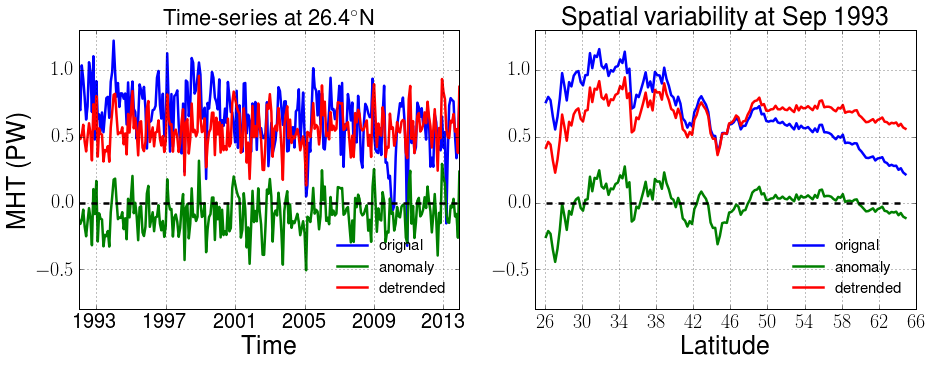

In [3]:
### Removing the temporal and meridional trends from the dataset using SciPy library

# Removing NaN
badi = (lat>=26) & (lat<=65)
lat = lat[badi]
mht = mht[:,badi]
i26 = np.abs(lat-26.5).argmin()


# Detrending - Scipy.signal.detrend will remove the average and trends along all axis, unless you specify it 
# using the keyword axis 
mht_anomaly = signal.detrend(mht, type='linear')


### Original dataset x anomaly exmaples
fig1,axes1 = plt.subplots(figsize=(15,5),nrows=1,ncols=2,facecolor='w')


## Ploting data
# time domain 
axes1[0].plot(date,mht[:,i26],'b',lw=2.5,label='orignal')
axes1[0].plot(date,mht_anomaly[:,i26],'g',lw=2.5,label='anomaly')
axes1[0].plot(date,mht_anomaly[:,i26]+mht[:,i26].mean(),'r',lw=2.5,label='detrended')
axes1[0].legend(numpoints=1,loc=0,prop={'size':15},frameon=False)
axes1[0].plot([date[0],date[-1]],[0,0],'k--',lw=2.5)

# spatial domain
axes1[1].plot(lat,mht[20,:],'b',lw=2.5,label='orignal')
axes1[1].plot(lat,mht_anomaly[20,:],'g',lw=2.5,label='anomaly')
axes1[1].plot(lat,mht_anomaly[20,:]+mht[20,:].mean(),'r',lw=2.5,label='detrended')
axes1[1].legend(numpoints=1,loc=0,prop={'size':15},frameon=False)
axes1[1].plot([lat[0],lat[-1]],[0,0],'k--',lw=2.5)

# Seting titles
axes1[0].set_title(ur'Time-series at 26.4$^{\circ}$N',fontsize=22,fontweight='demibold')
axes1[1].set_title(ur'Spatial variability at '+date[20].strftime("%b %Y"),fontsize=25,fontweight='demibold')

# Seting the axes
axes1[0].set_ylim(-0.8,1.3); axes1[1].set_ylim(-0.8,1.3);
axes1[0].set_xticks(date[range(12,253,48)]); axes1[1].set_xticks(range(26,69,4))
axes1[0].tick_params(labelsize=20); axes1[1].tick_params(labelsize=20)

axes1[0].set_ylabel("MHT (PW)",fontsize=25,fontweight='bold')
axes1[0].set_xlabel("Time",fontsize=25,fontweight='bold')
axes1[1].set_xlabel("Latitude",fontsize=25,fontweight='bold')

axes1[0].grid('on'); axes1[1].grid('on')

The figure above shows examples of how the anomalies look like. Now the next step is decompose the signal in sines and cosines.


## Part 2. Fourier Analysis at 26.4$^{\circ}$ N

#### Some characteristics of the time series

The time series extends from January-1992 to December-2013 and has a monthly resolution. Therefore:

    . bandwidth (or lowest solvable frequency): 
    
$$\frac{1\ cycle}{22\ years} \sim 0.045\ cycle\ per\ year$$
    
    . Nyquist frequency (or highest solvable frequency): 
$$\frac{1\ cycle}{2\ months} = 0.5\ cycle\ per\ month = 6\ cycles\ per\ year$$ 


As cited before (see Homework 2), we should expect a significant importance of oscillations in close to the seasonal frequency (i. e., $\frac{1}{12}$ cycle per month).  



In [4]:
### Computing the 1D Fourier Transform 
spec_26 = np.fft.fft(mht_anomaly[:,i26].squeeze())/time.shape[0]       # fft normalized by the number of frquencies


## Amplitude and phase of the oscillations
amplitude = np.abs(spec_26)
phase = np.angle(spec_26)


## Since the spectrum is symetric and the "information" is duplicated, 
## we will work only with the left half of the spec_26r 

# Frequency axis 
frequency = np.arange(time.shape[0]/2.)         # cycles per 22 years (T)
frequency = frequency/22.                       # cycles per year  


# Power units: [variance per frequency] 
amplitude2 = amplitude[0:(time.shape[0]/2)]*2.
amplitude2[0] = 0

# var(cos) = var(sin) = 0.5
power = (amplitude2**2)*0.5


# Cumulative variance: units [variance]
Cvar = np.concatenate(([0],np.cumsum(power)))
cfre = np.concatenate(([0],frequency))



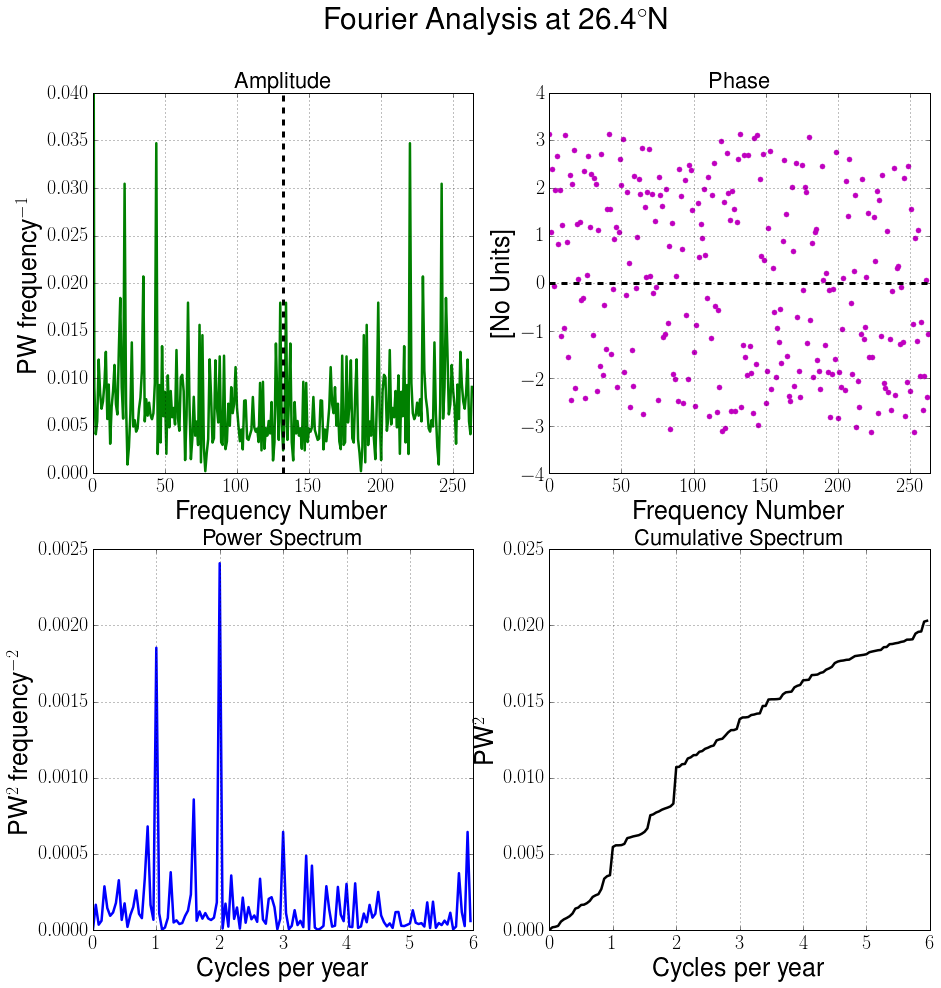

In [5]:
### Amplitude, phase, Power spectrum and cumulative variance graphs 
fig2,axes2 = plt.subplots(figsize=(15,15),nrows=2,ncols=2,facecolor='w')


## Amplitude
axes2[0,0].plot(amplitude,'g',lw=2.5)
axes2[0,0].plot([time.shape[0]/2,time.shape[0]/2],[0,0.04],'k--',lw=3.)

## Phase
axes2[0,1].plot(phase,'m.',markersize=10)
axes2[0,1].plot([0,time.shape[0]],[0,0],'k--',lw=3.)

## Power spectrum
axes2[1,0].plot(frequency,power,'b',lw=2.5)

## Cumulative variance
axes2[1,1].plot(cfre,Cvar,'k',lw=2.5)


## Seting titles
fig2.suptitle(ur'Fourier Analysis at 26.4$^{\circ}$N',fontsize=30,fontweight='demibold')
axes2[0,0].set_title('Amplitude$',fontsize=22,fontweight='demibold')
axes2[0,1].set_title('Phase',fontsize=22,fontweight='demibold')
axes2[1,0].set_title('Power Spectrum',fontsize=22,fontweight='demibold')
axes2[1,1].set_title('Cumulative Spectrum',fontsize=22,fontweight='demibold')

## Seting the axes 
axes2[0,0].set_ylim(0.,0.04)

axes2[0,0].set_xlim(0.,time.shape[0]); axes2[0,1].set_xlim(0.,time.shape[0])

axes2[0,0].tick_params(labelsize=20); axes2[0,1].tick_params(labelsize=20)
axes2[1,0].tick_params(labelsize=20); axes2[1,1].tick_params(labelsize=20)

axes2[0,0].set_ylabel(ur"PW frequency$^{-1}$",fontsize=25,fontweight='bold')
axes2[0,1].set_ylabel(ur"[No Units]",fontsize=25,fontweight='bold')
axes2[1,0].set_ylabel(ur"PW$^{2}$ frequency$^{-2}$",fontsize=25,fontweight='bold')
axes2[1,1].set_ylabel(ur"PW$^{2}$",fontsize=25,fontweight='bold')

axes2[0,0].set_xlabel("Frequency Number",fontsize=25,fontweight='bold')
axes2[0,1].set_xlabel("Frequency Number",fontsize=25,fontweight='bold')
axes2[1,0].set_xlabel("Cycles per year",fontsize=25,fontweight='bold')
axes2[1,1].set_xlabel("Cycles per year",fontsize=25,fontweight='bold')

axes2[0,0].grid('on'); axes2[0,1].grid('on');
axes2[1,0].grid('on'); axes2[1,1].grid('on');

As expected, an significant part of the variance is explained by the seasonal oscillation (i. e., 1 and 2 cycles per year). 

#### Time series reconstruction: 

The cumulative spectrum shows that more than half of the variance is explained by oscillations lower than 1.5 cycles per year. Therefore we can speculate how the time series would look like if no high frequencies were present. 

In [6]:
### Time series reconstruction 

# Selecting the low frequencies
Nfreq = np.arange(time.shape[0])
imodel = (Nfreq>0.25*Nfreq.max()) & (Nfreq<0.75*Nfreq.max())
amplitude[imodel] = 0.

# Build the synthetic spectrum from real and imaginary parts
new_spec = (amplitude*np.cos(phase)*time.shape[0]) + (1j*amplitude*np.sin(phase)*time.shape[0])

# Applying the inverse fourier transform
new_anomaly = np.real(np.fft.ifft(new_spec))


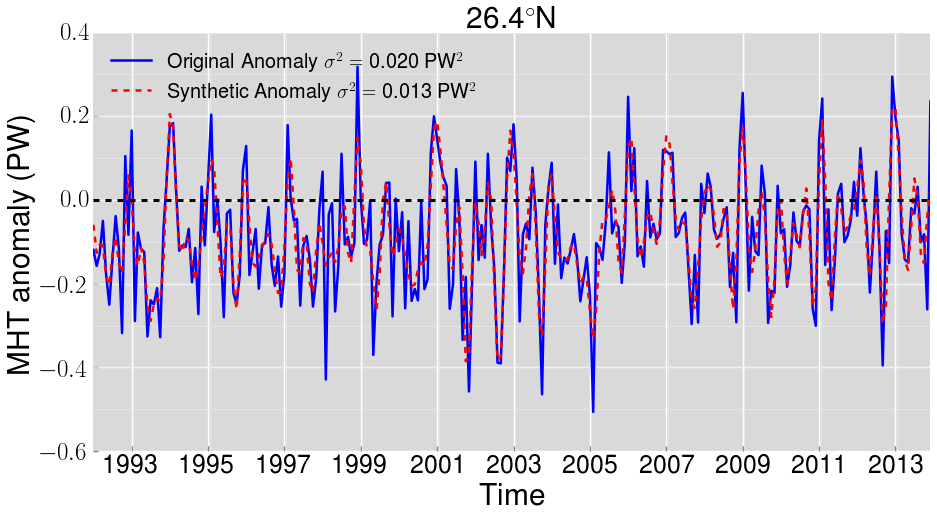

In [7]:
## MHT time-series at 26.4 N 
fig3 = plt.figure(num=3,figsize=(15,7.5),facecolor='w')
ax3 = plt.gca()

ax3.plot(date,mht_anomaly[:,i26],color='b',lw=2.5,
         label=ur'Original Anomaly $\sigma ^{2} =$ %1.3f PW$^{2}$'%(np.var(mht_anomaly[:,i26])))
ax3.plot(date,new_anomaly,'r--',lw=2.5,
         label=ur'Synthetic Anomaly $\sigma ^{2} =$ %1.3f PW$^{2}$'%(np.var(new_anomaly)))

ax3.legend(numpoints=1,loc=0,prop={'size':20},frameon=False)
ax3.plot([date[0],date[-1]],[0,0],'k--',lw=3.0)
rstyle(ax3)


# Seting the axes
ax3.set_xticks(date[range(12,253,24)])
ax3.tick_params(labelsize=25)

ax3.set_xlabel('Time',fontsize=30,fontweight='bold')
ax3.set_ylabel(ur'MHT anomaly (PW)',fontsize=30,fontweight='bold')
ax3.set_title(ur'%1.1f$^{\circ}$N'%(lat[i26]),fontsize=30,fontweight='bold')



## Part 3. 2-D Fourier Analysis 

In order to evaluate the spatial structure of the dataset, we can also apply the 2-dimensional fourier transform. Here we are going to look at the structure without relating it to anyphysical process.

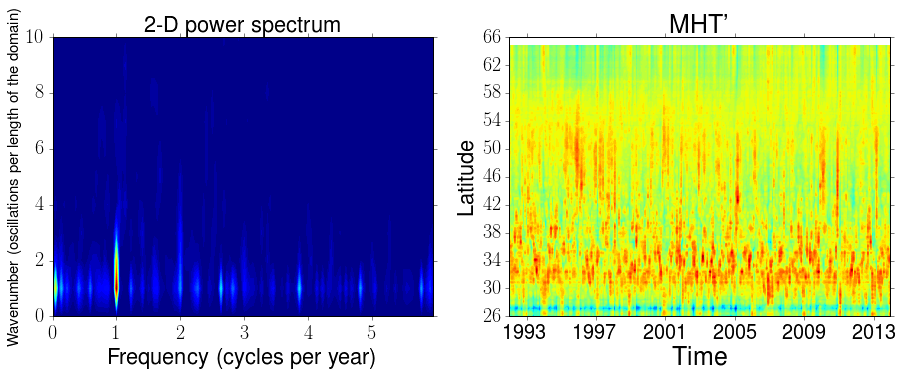

In [8]:
### 2D-spectrum
spec2d = np.fft.fft2(mht_anomaly)/(len(mht_anomaly))
amplitude = np.abs(spec2d)
amplitude = amplitude[:time.shape[0]/2,:lat.shape[0]/2]

amplitude2 = amplitude*2.
amplitude2[0,:] = 0
amplitude2[:,0] = 0

# var(cos) = var(sin) = 0.5
power = (amplitude2**2)*0.5

# Wavenumber and frequency axes
frequency = np.arange(time.shape[0]/2.)         # cycles per 22 years (T)
frequency = frequency/22.                       # cycles per year 
wavenumber = np.arange(lat.shape[0]/2.)         # cycles per 40 degrees of latitude 

### 2D spectrum x anomalies 
fig5,axes5 = plt.subplots(figsize=(15,5),nrows=1,ncols=2,facecolor='w')

cm1 = axes5[0].contourf(frequency,wavenumber,power.transpose(),50)
cm2 = axes5[1].contourf(date,lat,mht_anomaly.transpose(),50,extend='both')

# Seting titles
axes5[0].set_title('2-D power spectrum',fontsize=22,fontweight='demibold')
axes5[1].set_title("MHT'",fontsize=25,fontweight='demibold')

# Seting the axes
axes5[0].set_ylim(0,10); axes1[1].set_ylim(26.,66.);
axes5[1].set_xticks(date[range(12,253,48)]); axes5[1].set_yticks(range(26,69,4))
axes5[0].tick_params(labelsize=20); axes5[1].tick_params(labelsize=20)

axes5[0].set_ylabel("Wavenumber (oscillations per length of the domain)",fontsize=15,fontweight='bold')
axes5[1].set_ylabel("Latitude",fontsize=22,fontweight='bold')
axes5[0].set_xlabel("Frequency (cycles per year)",fontsize=22,fontweight='bold')
axes5[1].set_xlabel("Time",fontsize=25,fontweight='bold')

axes1[0].grid('on'); axes1[1].grid('on')


As we can see from the 2-D power spectrum, most of the variance is in seasonal oscillations. In terms of meridional structure the dominant oscillation has wavenumber of 1 cycle in the domain.  